In [2]:
%conda install -c conda-forge namaster

2 channel Terms of Service accepted
Channels:
 - conda-forge
 - defaults
Platform: osx-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 25.7.0
    latest version: 25.11.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [3]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import pymaster as nmt
from DES_CDM1 import cosmology, power_spectrum

Data import

In [4]:
hdufid = fits.open('data/sim_3x2_fiducial_nla.fits')
cls_fid = hdufid['galaxy_shear_cl'].data

hdudes = fits.open('data/2pt_NG_final_2ptunblind_02_24_21_wnz_redmagic_covupdate.fits')

data_source = hdudes['nz_source'].data[:-1]
data_lens = hdudes['nz_lens'].data[:-1]

Create dictionary for the lens and source data with the bin number as key value. For the redshift callibration, we also get the mean redshift per bin.

In [5]:
#redshift bins Redmagic
z_lims = np.array([0.15,0.35,0.5,0.65,0.8,0.9])

bin_number_source = 4
zs = np.array(data_source['Z_MID'])
zs_bins = []
zs_means = []
nz_source_dict = {}
for i in range(bin_number_source):
    z = zs[(zs >= z_lims[i]) & (zs < z_lims[i+1])]
    zs_bins.append(np.array(z))
    zs_means.append(np.mean(z))
    nz_source_dict[i] = data_source['BIN' + str(i+1)]


bin_number_lens = 5
zl = np.array(data_lens['Z_MID'])
zl_bins = []
zl_means = []
nz_lens_dict = {}
for i in range(bin_number_lens):
    z = zl[(zl >= z_lims[i]) & (zl < z_lims[i+1])]
    zl_bins.append(np.array(z))
    zl_means.append(np.mean(z))
    nz_lens_dict[i] = data_lens['BIN' + str(i+1)]

In [6]:
c = cosmology()
zmin = 0.1
zmax = max(zs.max(), zl.max())
k_grid = np.logspace(-4, 5, 100)*c.h  
kmin = k_grid.min()
kmax = k_grid.max()
ps_sub = power_spectrum(zmin=zmin, zmax=zmax,kmin=kmin+1e-8,kmax=kmax-1e-8,Pmm_file = "halo_model_power_spectra_substructure4.npz",Pmm_field= "P_hh_total")
ps_lin = power_spectrum(zmin=zmin, zmax=zmax,kmin=kmin+1e-8,kmax=kmax-1e-8)

kmin = 6.741e-05, kmax = 6.740e+04, chimin = 4.341e+02, chimax = 8.420e+03, zmin = 0.100, zmax = 5.990
Loaded Pmm from file: halo_model_power_spectra_substructure4.npz, field: P_hh_total
kmin = 6.741e-05, kmax = 6.740e+04, chimin = 4.341e+02, chimax = 8.420e+03, zmin = 0.100, zmax = 5.990
Computed Pmm using Colossus


In [7]:
# l bins are integers but close to the 
lmin = 8
lmax = 2048
n_bins = 32
nside = 1024

# Generate sqrt-spaced edges
sqrt_edges = np.linspace(np.sqrt(lmin), np.sqrt(lmax), n_bins + 1)
edges = sqrt_edges**2
edges = np.round(edges).astype(int)
edges[-1] = lmax + 1

# Create NaMaster binning object
b = nmt.NmtBin.from_edges(edges[:-1], edges[1:])
ells_binned = b.get_effective_ells()

In [8]:
print(lmax)
print(ells_binned)

2048
[  12.    23.    37.5   55.5   77.   102.   131.   163.   198.5  238.
  280.5  326.5  376.5  430.   486.5  546.5  610.5  678.   748.5  822.5
  900.5  982.  1066.5 1155.  1247.  1342.  1441.  1543.5 1649.5 1759.
 1872.  1989. ]


In [9]:
highdens = fits.open('data/y3a2_gold2.2.1_redmagic_highdens.fits')[1].data # Galaxy positions for bins 1-3
highlum = fits.open('data/y3a2_gold2.2.1_redmagic_highlum_highz.fits')[1].data # Galaxy positions for bins 4,5

random_highdens = fits.open('data/y3a2_gold2.2.1_redmagic_highdens_randoms.fits')[1].data # Random positions for bins 1-3
random_highlum = fits.open('data/y3a2_gold2.2.1_redmagic_highlum_highz_randoms.fits')[1].data # Random positions for bins 4,5

hdu_sel = fits.open('data/y3_gold_2.2.1_RING_joint_redmagic_v0.5.1_wide_maglim_v2.2_mask.fits') # Joint (Redmagic+Maglim) sky mask
pixel_index = hdu_sel[1].data['HPIX']        # pixel indices at NSIDE=4096
mask_value  = hdu_sel[1].data['FRACGOOD']    # fractional coverage

# Create empty HEALPix map
nside_in = 4096
npix_in = hp.nside2npix(nside_in)
mask_map = np.zeros(npix_in, dtype=np.float64)

# Fill map with values
mask_map[pixel_index] = mask_value

# Downgrade to your desired NSIDE for analysis
mask_sel = hp.ud_grade(mask_map, nside)

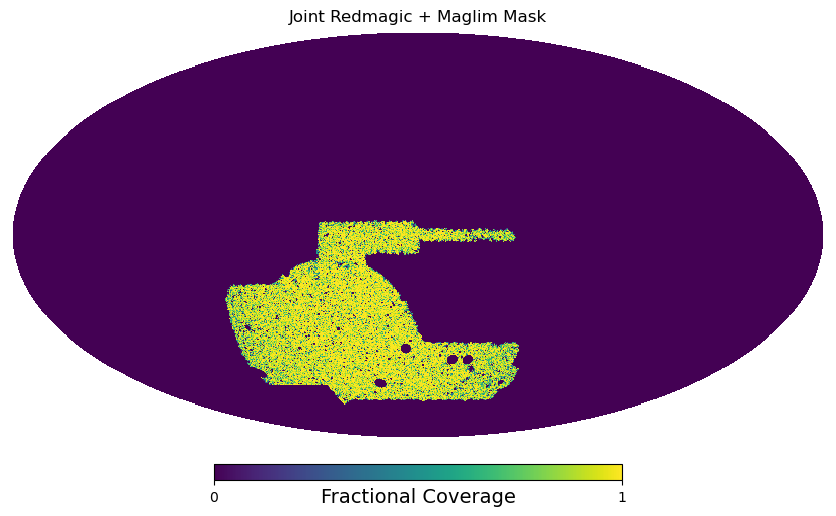

In [10]:
hp.mollview(mask_sel, title='Joint Redmagic + Maglim Mask', unit='Fractional Coverage')
plt.show()

In [11]:
#shear response for REDMAGIC
R_shear = np.array([0.7636,0.7182,0.6887,0.6154])
R_selection = np.array([0.0046,0.0083,0.0126,0.0145])
R = R_shear+R_selection

$$w_p \frac{\Sigma_pN_p}{\Sigma_p w_p}$$


In [12]:
shear_fields = {}
density_fields = {}

for i in range(1, 6):
    if i<4:
        mask_bin = highdens['BIN_NUMBER'] == i
        lens_galaxies_bin = highdens[mask_bin]
        mask_bin = random_highdens['BIN_NUMBER'] == i
        random_galaxies = random_highdens[mask_bin]
    else:
        mask_bin = highlum['BIN_NUMBER'] == i
        lens_galaxies_bin = highlum[mask_bin]
        mask_bin = random_highlum['BIN_NUMBER'] == i
        random_galaxies = random_highlum[mask_bin]

    ra = lens_galaxies_bin['RA']
    dec = lens_galaxies_bin['DEC']
    ipix = hp.ang2pix(nside, ra, dec, lonlat=True)

    ra_ran = random_galaxies['RA']
    dec_ran = random_galaxies['DEC']
    ipix_ran = hp.ang2pix(nside, ra_ran, dec_ran, lonlat=True)

    w_data = lens_galaxies_bin['WEIGHT']
    w_ran = np.ones(len(ra_ran), dtype=float)

    n_data = np.bincount(ipix, weights=w_data, minlength=hp.nside2npix(nside))
    n_ran  = np.bincount(ipix_ran,  weights=w_ran, minlength=hp.nside2npix(nside))

    good = (n_ran > 0) & (mask_sel > 0)
    delta = np.zeros_like(mask_sel, dtype=float)
    delta[good] = n_data[good] / n_ran[good] / np.mean(n_data[good] / n_ran[good]) - 1.0
    delta[~good] = -1

    density_fields[i] = nmt.NmtField(mask_sel, np.array([delta]), spin=0, lmax=lmax,lmax_mask=lmax)

    if i<5:
        mask_1024 = hp.read_map(f'data/DES_shear_maps/mask_shear_z{i}.fits')
        e1_1024 = hp.read_map(f'data/DES_shear_maps/shear_e1_z{i}.fits')
        e2_1024 = hp.read_map(f'data/DES_shear_maps/shear_e2_z{i}.fits')
        mask = hp.ud_grade(mask_1024, nside)
        e1 = hp.ud_grade(e1_1024, nside)
        e2 = hp.ud_grade(e2_1024, nside)

        e1 *= -1

        shear_fields[i] = nmt.NmtField(mask, np.array([e1, e2])/R[i-1], spin=2, lmax=lmax,lmax_mask=lmax)  


In [13]:
import os

outdir=f"cov_workspaces_nside{nside}"
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [ ]:
def get_cl(w,f1, f2):
    cl = w.decouple_cell(nmt.compute_coupled_cell(f1, f2))
    return cl

pcls = np.zeros((5,4,2,len(ells_binned)))
for i in range(1, 6):
    for j in range(1, 5):
        print(f"working on bins {i} {j}")
        w = nmt.NmtWorkspace.from_fields(density_fields[i], shear_fields[j], b)
        w.write_to(os.path.join(outdir, f"w{i}{j}.fits"))

        cw = nmt.NmtCovarianceWorkspace.from_fields(
                density_fields[i], shear_fields[j], density_fields[i], shear_fields[j]
            )
        cw.write_to(os.path.join(outdir, f"cw{i}{j}.fits"))
        

        pcl = get_cl(w, density_fields[i], shear_fields[j])
        pcls[i-1, j-1, :, :] = pcl

working on bins 1 1
working on bins 1 2
working on bins 1 3
working on bins 1 4
working on bins 2 1


In [ ]:
# Flatten so each row is (i, j, spec, cl[ell])
rows = []

for i in range(5):
    for j in range(4):
        for s in range(2):
            row = [i, j, s] + pcls[i, j, s, :].tolist()
            rows.append(row)

rows_array = np.array(rows)

# Save to CSV
np.savetxt(f"pcls_ge_nside{nside}.csv", rows_array, delimiter=",", fmt="%.6e")
print(f"pcls_ge_nside{nside}, l bins: {ells_binned}")

pcls_ge_nside1024, l bins: [  12.    23.    37.5   55.5   77.   102.   131.   163.   198.5  238.
  280.5  326.5  376.5  430.   486.5  546.5  610.5  678.   748.5  822.5
  900.5  982.  1066.5 1155.  1247.  1342.  1441.  1543.5 1649.5 1759.
 1872.  1989. ]
